In [50]:
import pandas as pd
import numpy as np
#from scipy.linalg import lu
import matplotlib.pyplot as plt

data=pd.read_table('test.txt',sep=',',header=None)

def transpose(A):
    return map(list,zip(*A))

def getMinor(A,i,j):
    B=np.zeros((len(A)-1,len(A)-1))
    for row,i in zip(np.concatenate((A[:i],A[i+1:]),axis=0),range(len(B))):
        B[i,:]=np.concatenate((row[:j],row[j+1:]),axis=0)
    return B #0是上下 1是左右

def determinant_recursive(A, total=0):
    # Section 1: store indices in list for row referencing
    indices = list(range(len(A))) 
    
    if len(A) == 2 and len(A[0]) == 2:
        val = A[0][0] * A[1][1] - A[1][0] * A[0][1]
        return val
    # Section 3: define submatrix for focus column and 
    #      call this function
    for fc in indices: # A) for each focus column, ...
        # find the submatrix ...
        As = A # B) make a copy, and ...
        
        As=getMinor(A,0,fc)
        sign = (-1) ** (fc % 2) # F) 
        #print('Min',As,fc)
        # G) pass submatrix recursively
        sub_det = determinant_recursive(As)
        # H) total all returns from recursion
        total += sign * A[0][fc] * sub_det 
 
    return total
#矩陣乘法
def dot(A,B):
    C=np.zeros((len(A),len(B.T)))
    for i in range(len(C)):
        for j in range(len(C.T)):
            a=0
            for k in range(len(A.T)):
                a+=A[i,k]*B[k,j]
            C[i,j]=a
    return C


def tri_inv(A):
    B=np.copy(A)
    #print(A,type(A))
    #print(len(A))
    if len(A)==2:
        B[0,0]=A[1,1]
        B[0,1]=-A[1,0]
        B[1,0]=-A[0,1]
        B[1,1]=A[0,0]
    else:
        for i in range(len(A)):
            for j in range(len(B)):
                sign=(-1)**((i+j)%2)
                B[i,j]=sign*determinant_recursive(getMinor(A,i,j))
                #print(getMinor(A,i,j),'\n det=',determinant_recursive(getMinor(A,i,j)))
                #print(B,i,j,'sign',sign)
    #print(determinant_recursive(A))
    #print(A,B)
    B=B.T*(1/determinant_recursive(A))
    return B


In [2]:
def check_pivot(A,column):
    max_item=0
    max_row=0
    for i in range(column,len(A)):
        if A[i][column]>max_item:
            max_item=A[i][column]
            max_row=i
    P = np.zeros((len(A),len(A)))
    for i in range(len(A)):
        P[i][i] = 1
    if column==max_row:
        #print('column==max_row',P)
        return P
    else:
        P[max_row][column]=1
        P[column][max_row]=1
        P[max_row][max_row]=0
        P[column][column]=0
        #print('column!=max_row',P)
        return P

In [39]:

def lu(A):
	
    n = len(A) # Give us total of lines
    #get L by P-1AU-1=L
    U=A
    #print('copy',U)
    P = np.zeros((n,n))
    for i in range(len(A)):
        P[i][i] = 1
    #print('generate',P)
	#Find L matrices
    for column in range(0,n): # for i in [0,1,2,..,n]
        P1=check_pivot(U,column)
        P=dot(P1,P)
        U=dot(P1,U)
        #print('check',P,U)
        for i in range(column+1,n): #不能減自己
            c=-U[i][column]/float(U[column][column])
            #print('i,column=',i,column)
            for j in range(column,n):
                U[i][j]+=c*U[column][j]
                #print('\n',U,c,i,j,column)
                if i>j:
                    U[i][j]=0
    L=dot(dot(tri_inv(P),A),tri_inv(U))
        
    #print(L,'U\n',U,'inv\n',tri_inv(U))
    return P,L,U

In [49]:
def Newton(A,y):
    x=np.random.randn(len(A.T)).reshape(-1,1)
    f1=2*dot(dot(A.T,A),x)-2*dot(A.T,y)
    Hf=2*dot(A.T,A)
    while f1.all()!=0:
        x=x-dot(tri_inv(Hf),f1)
        f1=2*dot(dot(A.T,A),x)-2*dot(A.T,y)
    return x


def program(x,y,n,λ=0):
    #power
    X=np.matrix(x).reshape(-1,1)
    A=np.matrix(x).reshape(-1,1)
    for i in range(n-2):
        A=np.append(A,np.power(X,i+2).reshape(-1,1),1)
    A=np.append(A,np.ones((len(x),1)),1)
    #print(A)
    if λ==0:
        p,l,u=lu(dot(A.T,A))
        #print(l)
        det_l=np.prod(np.diag(l))
        det_u=np.prod(np.diag(u))
        #print(det_l,det_u)
        if det_l !=0 and det_u != 0:
            #先略過自己KEY反矩陣的部分
            l_inv=tri_inv(l)
            u_inv=tri_inv(u)
            p_inv=tri_inv(p)
            B=dot(dot(u_inv,l_inv),p_inv)
            para=dot(dot(B,A.T),y)
            #print(para)
            para_new=Newton(A,y)
            print("LSE:\nFitting line:")
            for i in range(n-1):
                print("%f X^%d+"%(para[n-i-2],n-i-1))
            print("%f"%para[n-1])
            print('Total error: %f'%np.square(np.subtract(dot(A,para),y)).sum())
            print("Newton's Method':\nFitting line:")
            for i in range(n-1):
                print("%f X^%d+"%(para_new[n-i-2],n-i-1))
            print("%f"%para_new[n-1])
            print('Total error: %f'%np.square(np.subtract(dot(A,para_new),y)).sum())
        else:print("Singular!!!")
    else:
        p_new,l_new,u_new=lu(dot(A.T,A))
        
        det_l_new=np.prod(np.diag(l_new))
        det_u_new=np.prod(np.diag(u_new))
        p,l,u=lu(dot(A.T,A)+λ*np.identity(len(A.T)))
        det_l=np.prod(np.diag(l))
        det_u=np.prod(np.diag(u))
        if det_l_new !=0 and det_u_new != 0 and det_l !=0 and det_u != 0:
            #先略過自己KEY反矩陣的部分
            #Newton 要改
            l_inv=tri_inv(l)
            u_inv=tri_inv(u)
            p_inv=tri_inv(p)
            B=dot(dot(u_inv,l_inv),p_inv)
            para=dot(dot(B,A.T),y)
            l_new_inv=tri_inv(l_new)
            u_new_inv=tri_inv(u_new)
            p_new_inv=tri_inv(p_new)
            B_new=dot(dot(u_new_inv,l_new_inv),p_new_inv)
            para_new=dot(dot(B_new,A.T),y)
            print("LSE:\nFitting line:")
            for i in range(n-1):
                print("%f X^%d+"%(para[n-i-2],n-i-1))
            print("%f"%para[n-1])
            print('Total error: %f'%np.square(np.subtract(dot(A,para),y)).sum())
            print("Newton's Method:\nFitting line:")
            for i in range(n-1):
                print("%f X^%d+"%(para_new[n-i-2],n-i-1))
            print("%f"%para_new[n-1])
            print('Total error: %f'%np.square(np.subtract(dot(A,para_new),y)).sum())
        else:print("Singular!!!")
    fig, axs = plt.subplots(2, 1)
    axs[0].plot(x,y,'o',x,dot(A,para),'-')
    axs[0].set_title('LSE')
    axs[1].plot(x,y,'o',x,dot(A,para_new),'-')
    axs[1].set_title("Newton's Method")
    fig.tight_layout()
    plt.show()

In [12]:
x=data[0].values.reshape(-1,1)
y=data[1].values.reshape(-1,1)

LSE:
Fitting line:
0.834533 X^2+
0.093148 X^1+
0.046951
Total error: 22649.738493
Newton's Method:
Fitting line:
3.023853 X^2+
4.906190 X^1+
-0.231402
Total error: 26.559959


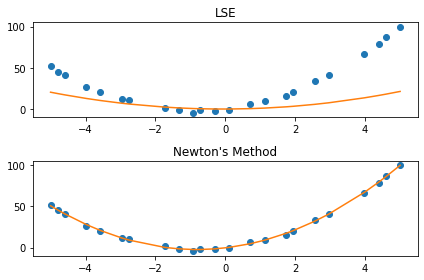

In [53]:
program(x,y,3,10000)

In [161]:
A=np.array([[1., 6., 0.],
 [5., 3., 3.],
 [0. ,0., 1.]])

In [13]:
[row[:j] + row[j+1:] for row in np.concatenate((A[:i],A[i+1:]),axis=0)]

numpy.ndarray